In [3]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import geopandas as gpd

In [4]:
baseline = Microsimulation()
baseline_income = baseline.calculate("real_household_net_income", period=2024)
baseline_people = baseline.calculate("people", map_to = "household", period=2024)

In [5]:
# Load the direct mapping matrix
mapping_matrix = pd.read_csv("mapping_2010_to_LAD2024.csv")
mapping_matrix = mapping_matrix.set_index(mapping_matrix.columns[0])

# Load weights
with h5py.File("../constituencies/weights.h5", "r") as f:
    weights = f["weight"][:]

# Apply mapping to weights
weights_lad = mapping_matrix.T.dot(weights)

# Calculate income and population for LADs
income_lad = np.dot(weights_lad, baseline_income.values)
population_lad = np.dot(weights_lad, baseline_people.values)
per_capita_lad = income_lad / population_lad

# Create final dataframe
lad_data = pd.DataFrame({
    'LAD24CD': mapping_matrix.columns,
    'income': per_capita_lad
})

# Add LAD names
constituency_lad = pd.read_csv("Constituency_to_LAD(2024).csv", 
                             usecols=['LAD24CD', 'LAD24NM'])
lad_data = lad_data.merge(
    constituency_lad[['LAD24CD', 'LAD24NM']].drop_duplicates(),
    on='LAD24CD',
    how='left'
)

lad_data.head()

,LAD24CD,income,LAD24NM
0,E06000001,14037.783074,Hartlepool
1,E06000002,14634.484076,Middlesbrough
2,E06000003,14986.287514,Redcar and Cleveland
3,E06000004,15046.469389,Stockton-on-Tees
4,E06000005,14985.379352,Darlington


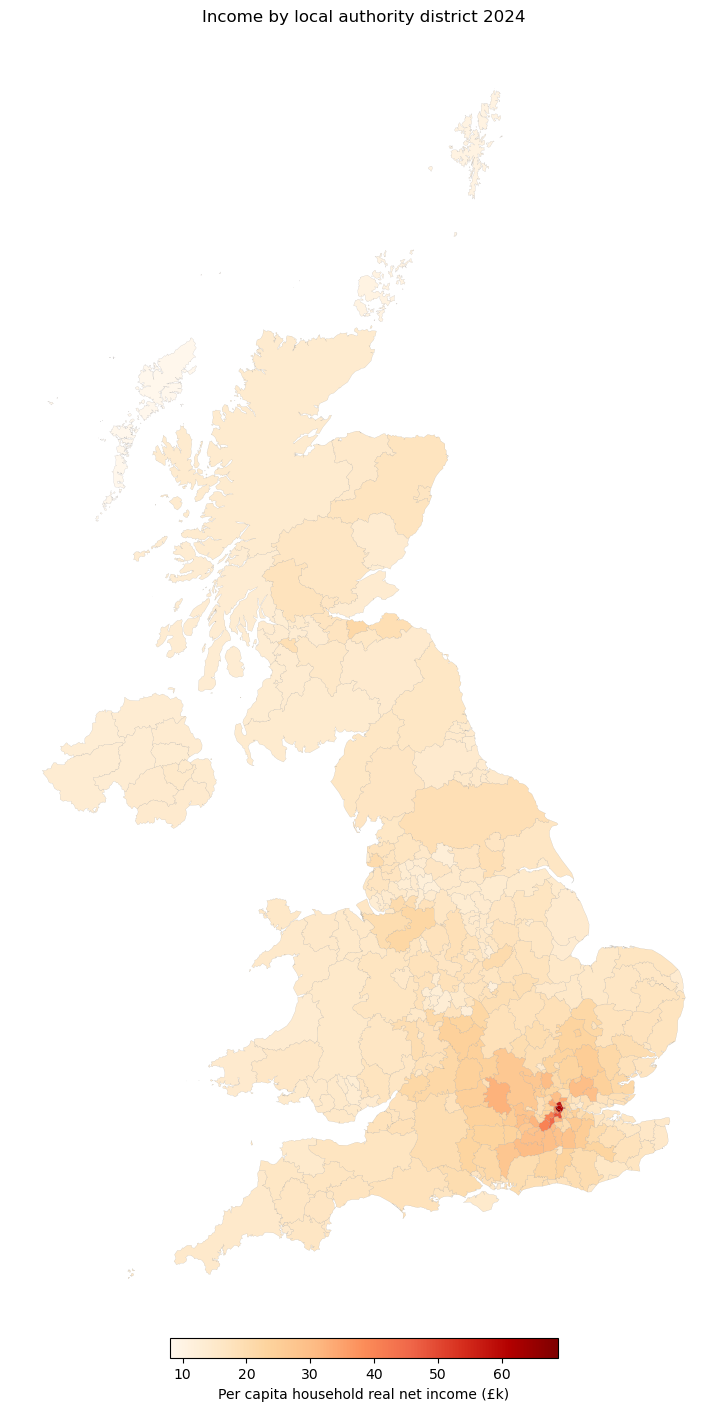

In [7]:
# Path to the zip file
zip_file_path = "Local_Authority_2024_Boundaries.zip"

# Extract the zip file
extracted_folder = "extracted_shapefile"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Find the .shp file in the extracted folder
shapefile_path = None
for root, dirs, files in os.walk(extracted_folder):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            
if shapefile_path:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Convert income to thousands for better visualization
    lad_data_copy = lad_data.copy()  # Using lad_data from our previous calculation
    lad_data_copy['income'] = lad_data_copy['income'] / 1000

    # Merge GeoDataFrame with our calculated income data
    merged_gdf = gdf.merge(lad_data_copy, on="LAD24CD", how="left")

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    merged_gdf.plot(
        column="income", 
        cmap="OrRd", 
        linewidth=0.08, 
        ax=ax, 
        edgecolor="0.5", 
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.0,
            'label': 'Per capita household real net income (£k)'
        }
    )
    ax.axis('off')
    plt.title("Income by local authority district 2024")
    plt.show()
    
    # Optional: Save the plot
    # plt.savefig('lad_income_map_2024.png', dpi=300, bbox_inches='tight')
else:
    print("No shapefile (.shp) found in the ZIP archive.")

In [10]:
LA_income_target = pd.read_csv("LA_income_target.csv")
# Convert to numeric with errors='coerce' to automatically convert invalid entries to NaN
LA_income_target['Mean'] = pd.to_numeric(LA_income_target['Mean'].replace('[\$,]', '', regex=True), errors='coerce')
LA_income_target.head()

,Description,Code,Mean
0,United Kingdom,K02000001,38224.0
1,Great Britain,K03000001,38413.0
2,England and Wales,K04000001,38661.0
3,England,E92000001,39004.0
4,North East,E12000001,32557.0


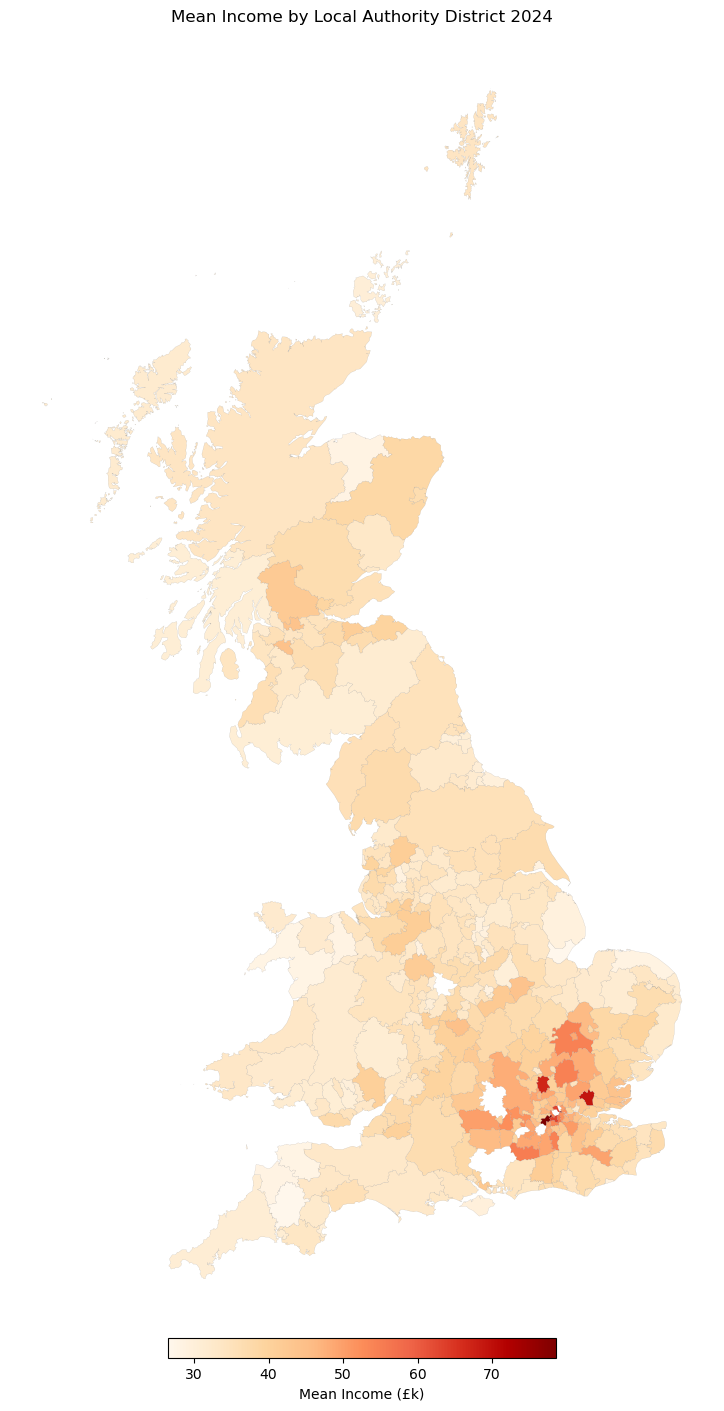

In [14]:

            
if shapefile_path:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Convert Mean to numeric if not already done
    LA_income_target['Mean'] = pd.to_numeric(LA_income_target['Mean'].replace('[\$,]', '', regex=True), errors='coerce')
    
    # Convert Mean to thousands for better visualization
    LA_income_target_copy = LA_income_target.copy()
    LA_income_target_copy['Mean'] = LA_income_target_copy['Mean'] / 1000

    # Merge GeoDataFrame with our Mean data
    merged_gdf = gdf.merge(LA_income_target_copy, left_on="LAD24CD", right_on="Code", how="left")

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    merged_gdf.plot(
        column="Mean", 
        cmap="OrRd", 
        linewidth=0.08, 
        ax=ax, 
        edgecolor="0.5", 
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.0,
            'label': 'Mean Income (£k)'
        }
    )
    ax.axis('off')
    plt.title("Mean Income by Local Authority District 2024")
    plt.show()
    
    # Optional: Save the plot
    # plt.savefig('lad_mean_income_map_2024.png', dpi=300, bbox_inches='tight')
else:
    print("No shapefile (.shp) found in the ZIP archive.")

In [12]:
# Check the column names in your DataFrames
print("LA_income_target columns:", LA_income_target.columns.tolist())
print("\nGeoDataFrame columns:", gdf.columns.tolist())

LA_income_target columns: ['Description', 'Code', 'Mean']

GeoDataFrame columns: ['LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'geometry']
